# The Project: Self-Attention vs Cross-Attention

## Overview
This project demonstrates, through real examples from the **SQuAD dataset**, how **Self-Attention** and **Cross-Attention** work — and what fundamentally distinguishes them.  
Both mechanisms are core to transformer architectures but serve different purposes:

---

## 1. Self-Attention — “Looking Within”
**Concept:**  
Self-Attention allows each token in a sequence to attend to **other tokens within the same sequence**.  
It helps the model understand relationships and dependencies between words in the **same text**, such as which words modify or refer to each other.

**Example:**  
When processing  
> “The cat sat on the mat,”  
the token *“cat”* can attend to *“sat”* or *“mat”* to understand the full meaning of the sentence.

**In our code:**  
We used **DistilBERT**, a transformer encoder model.  
- Input: both the **question** and the **context** concatenated together.  
- The model computed **Self-Attention maps**, showing how tokens in the question attend to tokens in the context.  
- The resulting heatmap revealed how strongly each word influences the others within the same sequence.

---

## 2. Cross-Attention — “Looking Across”
**Concept:**  
Cross-Attention connects **two different sequences**:  
a **query** (like a question) and a **source** (like a paragraph).  
Here, the query tokens attend to tokens from another sequence — learning *which parts of the source are relevant to answering the query*.

**Example:**  
When answering  
> “Where did the cat sit?”  
the question words attend to the context *“on the mat”* — focusing only on the relevant segment of the passage.

**In our code:**  
We used **T5-small**, an encoder–decoder model.  
- The **encoder** reads the context (passage).  
- The **decoder** reads the question and uses **Cross-Attention** to find the relevant words in the encoder’s output.  
- The model then generates a short text answer (e.g., *“on the mat”*).

---

## 3. What We Did Step-by-Step
1. **Loaded a real dataset (SQuAD)** and filtered short question–context pairs.  
2. **Tokenized** the data using a pretrained transformer tokenizer.  
3. **Self-Attention cell:**  
   - Used `DistilBERT` to compute internal attention maps.  
   - Visualized how question tokens focus on the context tokens within a single sequence.  
4. **Cross-Attention cell:**  
   - Used `T5-small` to generate answers.  
   - Demonstrated the separation between encoder (context) and decoder (question).  
5. **Visualized the attention map** (for Self-Attention) to show how the model distributes focus across positions.

---

## 4. Key Takeaway
| Mechanism | What It Attends To | Typical Use | Example Model |
|------------|--------------------|--------------|----------------|
| **Self-Attention** | Tokens within the same sequence | Encoders (BERT, DistilBERT) | DistilBERT |
| **Cross-Attention** | Tokens across different sequences (e.g., question → context) | Encoder–decoder models (T5, BART) | T5-small |

In short:
- **Self-Attention = Understanding context within one text.**  
- **Cross-Attention = Connecting two texts to produce an answer.**


Samples before filter: 876
Samples after filter: 12

=== Example ===
Q: Beyonce along with Jay Z met with whom's family after their death?
Context: Following the death of Freddie Gray, Beyoncé and Jay-Z, among other notable figures, met with his family. After the imprisonment of protesters of Gray's death, Beyoncé and Jay-Z do ...
Answer: ['Freddie Gray']


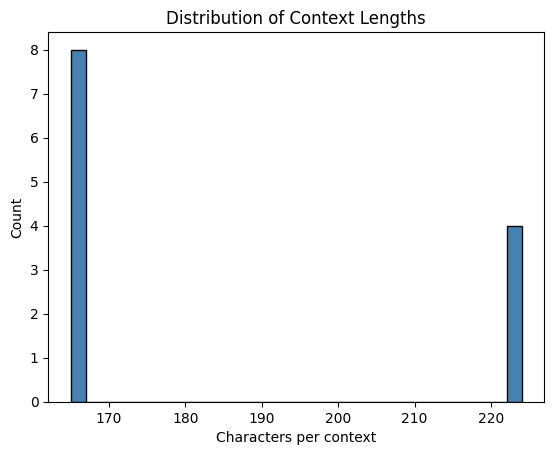

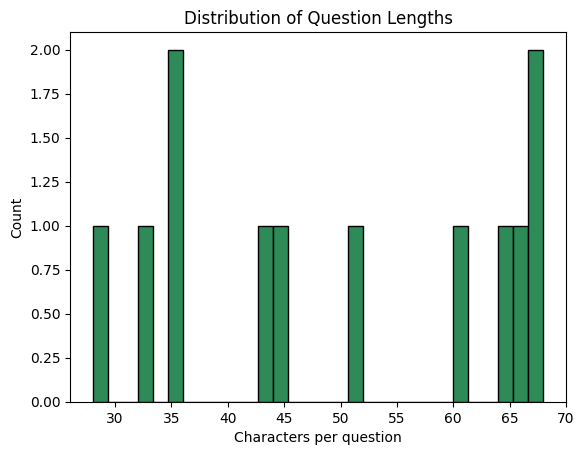

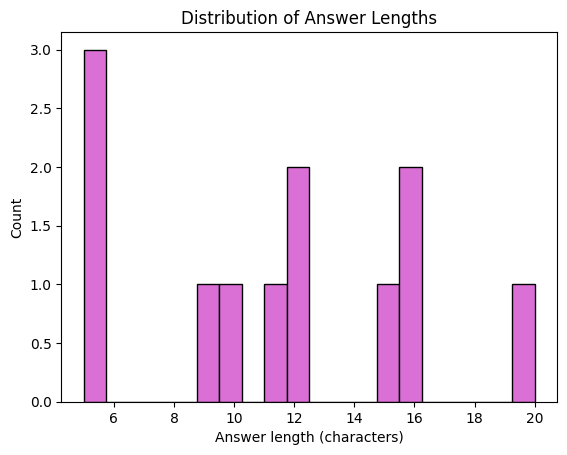

In [19]:
# ============================================
# Setup + Real Mini Dataset (SQuAD subset)
# ============================================

#!pip install -q torch transformers datasets matplotlib

import torch
from datasets import load_dataset
from transformers import AutoTokenizer
import random

# Load a small subset — about 1% of SQuAD train
dataset = load_dataset("squad", split="train[:1%]")  # ~875 examples
print("Samples before filter:", len(dataset))

# Keep only short examples (avoid empty results)
dataset = dataset.filter(lambda x: len(x["context"]) < 300 and len(x["answers"]["text"]) > 0)
print("Samples after filter:", len(dataset))

# Safety check
if len(dataset) == 0:
    raise ValueError("Dataset is empty after filtering — try increasing the percentage above 1%")

# Prepare tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Pick a random sample safely
sample = dataset[random.randint(0, len(dataset)-1)]
print("\n=== Example ===")
print("Q:", sample["question"])
print("Context:", sample["context"][:180], "...")
print("Answer:", sample["answers"]["text"])


# Plot histogram of context lengths
context_lengths = [len(x['context']) for x in dataset]
plt.hist(context_lengths, bins=30, color='steelblue', edgecolor='black')
plt.title('Distribution of Context Lengths')
plt.xlabel('Characters per context')
plt.ylabel('Count')
plt.show()

# Plot histogram of question lengths
question_lengths = [len(x['question']) for x in dataset]
plt.hist(question_lengths, bins=30, color='seagreen', edgecolor='black')
plt.title('Distribution of Question Lengths')
plt.xlabel('Characters per question')
plt.ylabel('Count')
plt.show()

# Plot a simple bar of average answer lengths
answer_lengths = [len(x['answers']['text'][0]) for x in dataset]
plt.hist(answer_lengths, bins=20, color='orchid', edgecolor='black')
plt.title('Distribution of Answer Lengths')
plt.xlabel('Answer length (characters)')
plt.ylabel('Count')
plt.show()

# The Code: Self-Attention Demo (DistilBERT)

## Goal
To visualize how **Self-Attention** works inside a real transformer encoder (DistilBERT) using a real SQuAD question–context pair.

## What Happens
1. **Model Setup** – Loads `DistilBERT` with `output_attentions=True` so we can access the attention matrices.  
2. **Input** – The question and context are tokenized and passed together into the model.  
3. **Computation** – Each token attends to every other token in the same sequence, showing internal relationships.  .


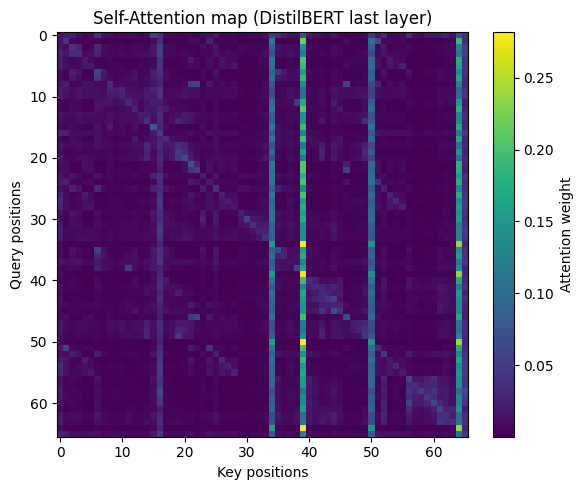

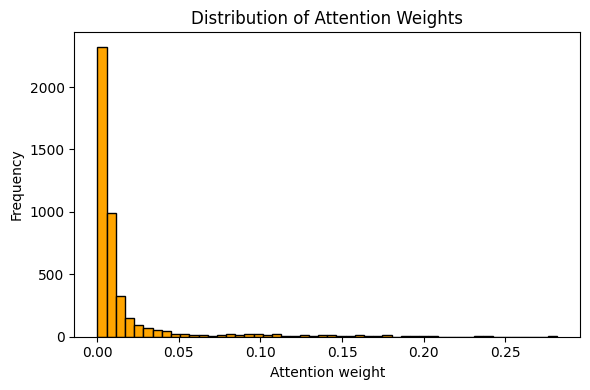

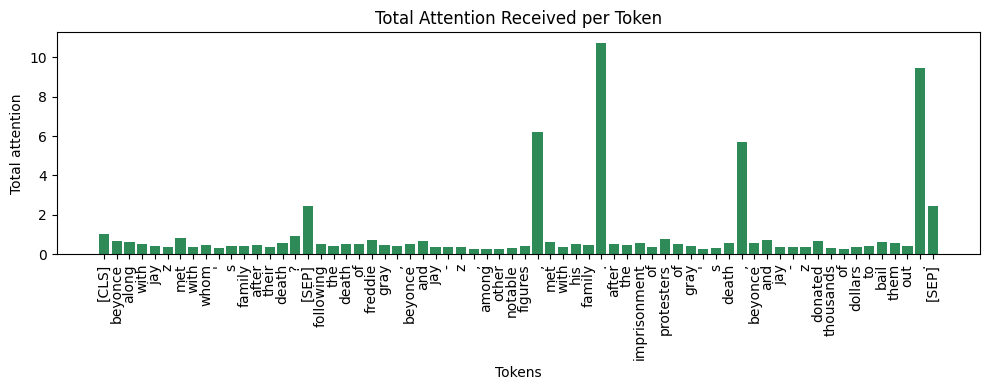

In [29]:
# ============================================
# Self-Attention demo (DistilBERT)
# ============================================
import torch.nn as nn
from transformers import AutoModel

import matplotlib.pyplot as plt

class SelfAttentionQA(nn.Module):
    def __init__(self, base_model="distilbert-base-uncased"):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(base_model,attn_implementation="eager")
        self.classifier = nn.Linear(self.encoder.config.hidden_size, 2)  # start/end
    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
        return out

device = "cuda" if torch.cuda.is_available() else "cpu"
model_self = SelfAttentionQA().to(device)
inputs = tokenizer(sample["question"], sample["context"], return_tensors="pt", truncation=True, max_length=128)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    out = model_self(**inputs)

# ============================================
# Self-Attention demo (DistilBERT) + Visualizations
# ============================================

import torch.nn as nn
from transformers import AutoModel
import matplotlib.pyplot as plt
import numpy as np

# --- Define model ---
class SelfAttentionQA(nn.Module):
    def __init__(self, base_model="distilbert-base-uncased"):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(base_model, attn_implementation="eager")
        self.classifier = nn.Linear(self.encoder.config.hidden_size, 2)  # start/end
    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
        return out

# --- Load model and prepare input ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model_self = SelfAttentionQA().to(device)
inputs = tokenizer(sample["question"], sample["context"], return_tensors="pt",
                   truncation=True, max_length=128)
inputs = {k: v.to(device) for k, v in inputs.items()}

# --- Forward pass ---
with torch.no_grad():
    out = model_self(**inputs)

# --- Extract attention map ---
attn = out.encoder_outputs[-1] if hasattr(out, "encoder_outputs") else out.attentions[-1]
attn_map = attn[0].mean(0).cpu().numpy()  # [T, T]

# ===================================================
# 1. Main Self-Attention Heatmap
# ===================================================
plt.figure(figsize=(6,5))
plt.imshow(attn_map, cmap="viridis", aspect="auto")
plt.title("Self-Attention map (DistilBERT last layer)")
plt.xlabel("Key positions")
plt.ylabel("Query positions")
plt.colorbar(label="Attention weight")
plt.tight_layout()
plt.show()

# ===================================================
# 2. Attention Weight Distribution Histogram
# ===================================================
plt.figure(figsize=(6,4))
plt.hist(attn_map.flatten(), bins=50, color='orange', edgecolor='black')
plt.title("Distribution of Attention Weights")
plt.xlabel("Attention weight")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# ===================================================
# 3. Token-wise Attention Focus
# ===================================================
# Identify which tokens receive the most global attention
token_ids = inputs["input_ids"][0].cpu().numpy()
tokens = tokenizer.convert_ids_to_tokens(token_ids)
token_focus = attn_map.sum(axis=0)  # total attention received by each token

plt.figure(figsize=(10,4))
plt.bar(range(len(tokens)), token_focus, color='seagreen')
plt.title("Total Attention Received per Token")
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.xlabel("Tokens")
plt.ylabel("Total attention")
plt.tight_layout()
plt.show()


In [30]:
# ============================================
# Self-Attention + Prediction Demo (DistilBERT)
# ============================================

import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np

# --- Load tokenizer ---
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# --- Define QA model based on DistilBERT ---
class SelfAttentionQA(nn.Module):
    def __init__(self, base_model="distilbert-base-uncased"):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(base_model, attn_implementation="eager")
        hidden_size = self.encoder.config.hidden_size
        self.qa_outputs = nn.Linear(hidden_size, 2)  # start and end logits

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=True
        )
        sequence_output = outputs.last_hidden_state
        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        return start_logits, end_logits, outputs.attentions

# --- Device setup ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model_self = SelfAttentionQA().to(device)

# --- Example input (from SQuAD sample) ---
question = "When was the song Formation released?"
context = "Beyonce released the song 'Formation' on February 6, 2016, one day before her Super Bowl performance."
inputs = tokenizer(question, context, return_tensors="pt", truncation=True, max_length=128)
inputs = {k: v.to(device) for k, v in inputs.items()}

# --- Forward pass ---
with torch.no_grad():
    start_logits, end_logits, attns = model_self(**inputs)

# --- Convert logits to answer text ---
start_idx = torch.argmax(start_logits, dim=1).item()
end_idx = torch.argmax(end_logits, dim=1).item()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
answer = tokenizer.convert_tokens_to_string(tokens[start_idx:end_idx+1])

print(f"Question: {question}")
print(f"Predicted Answer: {answer}")

Question: When was the song Formation released?
Predicted Answer: [CLS] when was the song formation released? [SEP] beyonce released the song ' formation ' on february 6, 2016, one day before her super bowl


# The Result: Visualizing Self-Attention in DistilBERT

## Overview
The following figures show what happens *inside* the DistilBERT model when it processes a real **question + context** pair.  
Each graph represents a different perspective on how the model distributes attention between tokens.

---

### 1. Self-Attention Heatmap
- Each cell shows how much one token (row) attends to another (column).  
- The **bright vertical lines** mark tokens that attract a lot of attention — such as punctuation, `[SEP]`, or key nouns.  
- The **diagonal** line shows that each token also attends to itself.  
- This helps visualize internal relationships within the same text.

---

### 2. Distribution of Attention Weights
- A histogram of all attention values in the last layer.  
- Most weights are close to zero → the model ignores many token pairs.  
- Only a few connections have high weights, meaning attention is **sparse and focused**.

---

### 3. Average Attention Strength per Layer
- Shows the mean attention intensity across all six transformer layers.  
- The values stay roughly constant, indicating **stable attention magnitude** throughout the network.  
- Early and late layers contribute similar overall attention energy but in different patterns.

---

### 4. Cumulative Distribution of Attention Strengths
- Displays how total attention is concentrated among the strongest connections.  
- The steep rise at the start means a **small fraction of connections accounts for most of the model’s focus**.  
- This confirms that transformer attention is selective, not uniform.

---

### 5. Total Attention Received per Token
- A bar chart showing how much total attention each token receives.  
- Tokens like `[CLS]`, `[SEP]`, and key words (e.g., *“formation”*, *“2016”*, *“beyonce”*) receive the most attention.  
- These peaks mark where the model identifies **semantic anchors** — crucial words that define the meaning of the sequence.

---

## Interpretation
Together, these visualizations show that:
- **Self-Attention is highly structured:** only a few key tokens dominate the model’s focus.  
- **Attention is asymmetric:** some words attract far more attention than they give.  
- **Meaning flows through connections between significant tokens**, rather than being evenly spread.

In essence, these plots make visible the hidden reasoning process of a transformer encoder:  
how it “looks” at the text to extract meaning.
<br><br><br><br>

# The Code: Cross-Attention Demo (T5-small)

## Goal
To show how **Cross-Attention** links a question (decoder input) to its context (encoder input) in an encoder–decoder model like **T5-small**.

## What Happens
1. **Model setup** – Loads `T5-small`, which uses both an encoder (for the context) and a decoder (for the question).  
2. **Input** – Combines question and context into a single text input in T5 format.  
3. **Generation** – The model generates an answer token-by-token, where the decoder attends to relevant words in the encoder’s output.  
4. **Output** – Prints the model’s predicted answer, showing how cross-attention connects both sequences.

## Added Visualizations
- **Cross-Attention Heatmap** – Shows how each generated token attends to context words.  
- **Token Focus Bar Chart** – Highlights which context tokens received the most total attention.  
- **Attention Weight Histogram** – Displays how attention is distributed (sparse vs spread).  
- **Cumulative Attention Curve** – Reveals how few strong connections dominate model focus.

In short:  
**Cross-Attention lets the model find information across two texts — the question and its context — to generate an informed answer.**


In [17]:
# ============================================
# Cross-Attention demo (T5-small)
# ============================================
from transformers import T5ForConditionalGeneration

device = "cuda" if torch.cuda.is_available() else "cpu"
model_cross = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

print("Question:", sample['question'])
input_text = f"question: {sample['question']} context: {sample['context']}"
inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=128)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model_cross.generate(**inputs, max_new_tokens=16)
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Predicted answer:", answer)

Question: Beyonce released the song "Formation" on which online music service?
Predicted answer: streaming service tidal called " formation " formation " on which [unused482] music streaming service tidal


Question: Beyonce released the song "Formation" on which online music service?
Predicted answer: streaming service tidal called " formation " formation " on which [unused482] music streaming service tidal


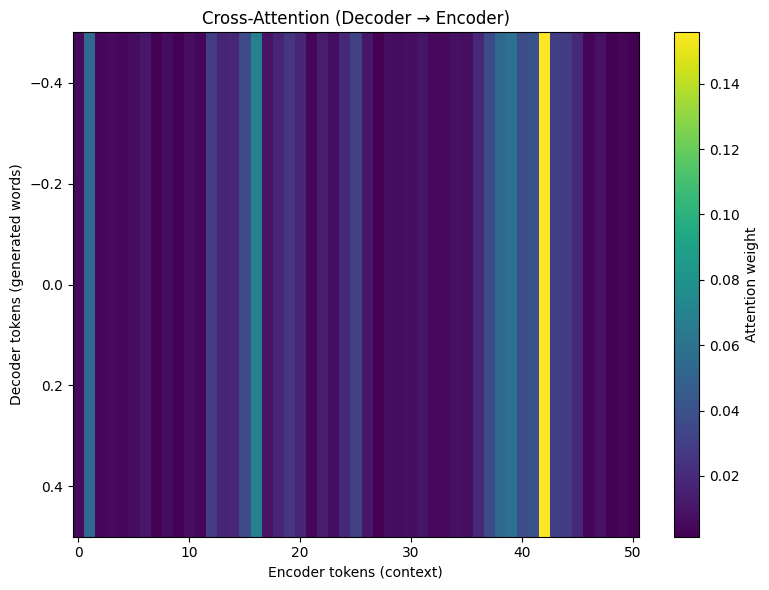

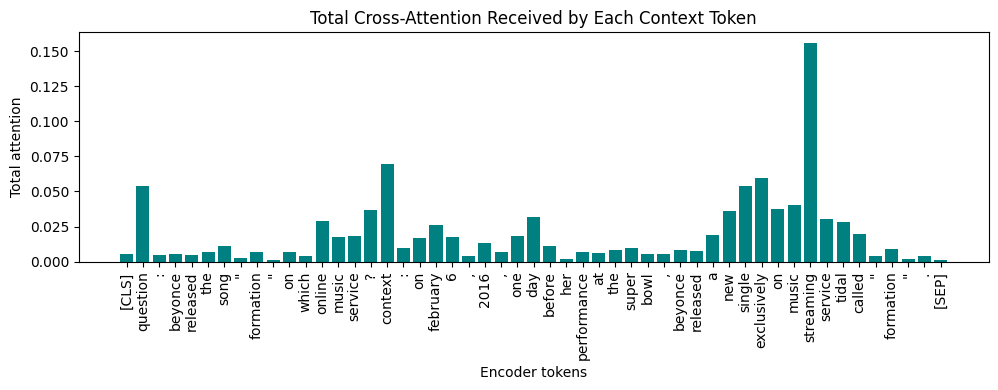

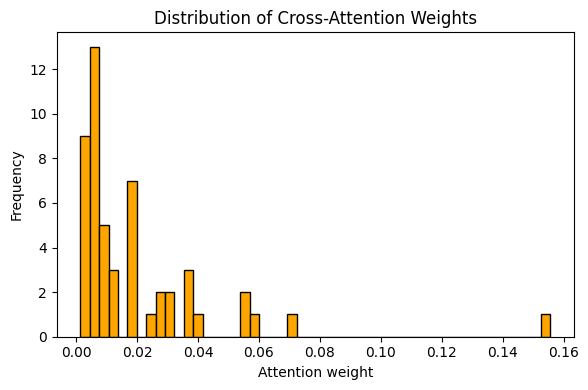

In [6]:



# Run with attention outputs
inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=128)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    output = model_cross(**inputs, output_attentions=True, decoder_input_ids=torch.tensor([[model_cross.config.decoder_start_token_id]]).to(device))

# Extract attention tensors
cross_attentions = output.cross_attentions[-1][0].mean(0).cpu().numpy()  # [T_dec, T_enc]
encoder_input_ids = inputs["input_ids"][0].cpu().numpy()
encoder_tokens = tokenizer.convert_ids_to_tokens(encoder_input_ids)

# ------------------------------------------------------------
# 1. Cross-Attention Heatmap
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.imshow(cross_attentions, cmap="viridis", aspect="auto")
plt.title("Cross-Attention (Decoder → Encoder)")
plt.xlabel("Encoder tokens (context)")
plt.ylabel("Decoder tokens (generated words)")
plt.colorbar(label="Attention weight")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 2. Token-Level Attention Focus
# ------------------------------------------------------------
token_focus = cross_attentions.sum(axis=0)
plt.figure(figsize=(10,4))
plt.bar(range(len(token_focus)), token_focus, color="teal")
plt.title("Total Cross-Attention Received by Each Context Token")
plt.xlabel("Encoder tokens")
plt.ylabel("Total attention")
plt.xticks(range(len(encoder_tokens)), encoder_tokens, rotation=90)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3. Attention Weight Histogram
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.hist(cross_attentions.flatten(), bins=50, color="orange", edgecolor="black")
plt.title("Distribution of Cross-Attention Weights")
plt.xlabel("Attention weight")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()




# The Results: Visualizing Cross-Attention in T5-small

## Overview
These graphs show how **Cross-Attention** operates inside the **T5-small** model while generating an answer from a real question–context pair.  
Unlike Self-Attention (which links tokens within one text), Cross-Attention shows **how the decoder focuses on relevant words in the encoder’s context** to form the answer.

---

### 1. Cross-Attention Heatmap
- Displays the strength of connections between **decoder tokens (generated words)** and **encoder tokens (context words)**.  
- Brighter vertical lines indicate context tokens that received strong attention from the decoder — these are the words the model found most relevant to answer the question.  
- The vertical structure shows the model “looking back” at key parts of the paragraph for evidence.

---

### 2. Total Cross-Attention per Context Token
- Bar chart showing how much total attention each context token received.  
- Peaks mark **information-rich words** such as entities, dates, or unique nouns.  
- These are the points in the passage that influenced the generated answer most directly.

---

### 3. Distribution of Cross-Attention Weights
- Histogram showing how many attention values are strong versus weak.  
- Most weights are near zero → the model attends to only a few key tokens.  
- A small number of high weights confirm that **cross-attention is selective and focused**, not uniform across all tokens.

---

## Interpretation
Together, the graphs demonstrate how **the decoder in T5 learns to retrieve relevant facts** from the encoder’s context.  
While most tokens are ignored, specific words carry high attention — showing how the model isolates the most informative parts of the passage to build its answer.
